In [67]:
# https://guarana001.hateblo.jp/entry/2020/07/26/134446

import os
import shutil
import pandas as pd
from glob import glob
from tqdm import tqdm
import cv2
import numpy as np
import pydicom
import math


In [68]:
IMG_DIR = './Dataset/'

In [69]:
resize_dimension = 512
image_size = [resize_dimension, resize_dimension]
index = 0
parts = 1

### Process meta data
##### Adopt only data with 'injury_name' as training data.

In [70]:
train_df = pd.read_csv('./rsna2023atd_files/train.csv')
img_lvl_df = pd.read_csv('./rsna2023atd_files/image_level_labels.csv')
train_df = train_df.merge(img_lvl_df, on=['patient_id'], how='right')

train_df['image_path'] = (f'./rsna2023atd_files/train_images/'
                          + train_df.patient_id.astype(str)+ '/' 
                          + train_df.series_id.astype(str) + '/' 
                          + train_df.instance_number.astype(str) 
                          + '.dcm')


In [71]:
test_paths = glob('./rsna2023atd_files/test_images/*/*/*.dcm')

test_df = pd.DataFrame(test_paths, columns=['image_path'])
test_df['patient_id'] = test_df['image_path'].map(lambda x: x.split('/')[-3]).astype(int)
test_df['series_id'] = test_df['image_path'].map(lambda x: x.split('/')[-2]).astype(int)
test_df['instance_number'] = test_df['image_path'].map(lambda x: x.split('/')[-1])
test_df['instance_number'] = test_df['instance_number'].map(lambda x: x.replace('.dcm', '')).astype(int)

### Convert .dcm to .png

In [72]:
os.makedirs('./train_png', exist_ok = True)
os.makedirs('./test_png', exist_ok = True)

In [73]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:

    '''
    https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    https://www.kaggle.com/code/theoviel/get-started-quicker-dicom-png-conversion
    https://www.kaggle.com/code/alenic/dataset-size-reduction-400gb-to-7-5gb
    '''

    pixel_array = dcm.pixel_array

    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        new_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
        # https://www.eizo.co.jp/products/tech/files/2004/wp_jp_04_001_grayscale.pdf
        # https://www.classcat.com/medical_ai/tag/pydicom-2-2-user-guide/
        pixel_array = pydicom.pixel_data_handlers.util.apply_modality_lut(new_array, dcm)
    
    return pixel_array


# https://dicom.nema.org/medical/Dicom/2018d/output/chtml/part03/sect_C.7.6.3.html
def read_xray(file_path, fix_monochrome = True):

    dicom = pydicom.dcmread(file_path)
    data = standardize_pixel_array(dicom)
    data = data - np.min(data)
    data = data / (np.max(data) + 1e-5)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
        
    return data


def resize_and_save(file_path):
    image = read_xray(file_path)
    height = image.shape[0]
    width = image.shape[1]
    image = cv2.resize(image, (resize_dimension, resize_dimension), cv2.INTER_LINEAR) # bilinear interpolation
    image = (image * 255).astype(np.uint8)

    sub_path = file_path.split('/')[-4] + '/' +file_path.split('/')[-3] + '/' + file_path.split('/')[-2] + '/' + file_path.split('/')[-1].split('.')[0] + '.png'

    infos = sub_path.split('/')
    patient_id = infos[1]
    series_id = infos[2]
    instance_id = infos[3] ; instance_id = instance_id.replace('.png', '')

    new_path = os.path.join(IMG_DIR, sub_path)
    os.makedirs(new_path.rsplit('/',1)[0], exist_ok=True)

    cv2.imwrite(new_path, image, [cv2.IMWRITE_PNG_COMPRESSION, 0])

    return patient_id,series_id,instance_id,width,height

In [74]:
%%time
from joblib import Parallel, delayed
file_paths = train_df.image_path.tolist()
# https://qiita.com/Jungle-King/items/1d332a91647a3d996b82
imagesize_train = Parallel(n_jobs=-1,backend='threading')(delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths, leave=True, position=0))

100%|██████████| 12029/12029 [00:59<00:00, 203.20it/s]


CPU times: user 1min 18s, sys: 25.6 s, total: 1min 44s
Wall time: 59.3 s


In [75]:
pid, sid, iid, width, height = list(zip(*imagesize_train))

meta_df = pd.DataFrame({'patient_id'     : pid,
                        'series_id'      : sid,
                        'instance_number': iid,
                        'width'          : width,
                        'height'         : height})
meta_df[['patient_id', 'series_id', 'instance_number']] = meta_df[['patient_id', 'series_id', 'instance_number']].astype(int)

train_df = train_df.merge(meta_df, on=['patient_id','series_id','instance_number'], how='right')
train_df['image_path'] = f'./Dataset/train_images/' + \
                            train_df.patient_id.astype(str) + '/' + \
                            train_df.series_id.astype(str) + '/' + \
                            train_df.instance_number.astype(str) + '.png'

In [76]:
train_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,image_path,width,height
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,./Dataset/train_images/10004/21057/362.png,512,512
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,./Dataset/train_images/10004/21057/363.png,512,512
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,./Dataset/train_images/10004/21057/364.png,512,512
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,./Dataset/train_images/10004/21057/365.png,512,512
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,./Dataset/train_images/10004/21057/366.png,512,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13010,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,155,Active_Extravasation,./Dataset/train_images/9632/3750/155.png,512,512
13011,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,156,Active_Extravasation,./Dataset/train_images/9632/3750/156.png,512,512
13012,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,157,Active_Extravasation,./Dataset/train_images/9632/3750/157.png,512,512
13013,9632,1,0,0,1,1,0,0,1,0,...,1,0,0,1,3750,158,Active_Extravasation,./Dataset/train_images/9632/3750/158.png,512,512


In [77]:
%%time
file_paths = test_df.image_path.tolist()
imagesize_test = Parallel(n_jobs=-1,backend='threading')(delayed(resize_and_save)(file_path) for file_path in tqdm(file_paths))

100%|██████████| 3/3 [00:00<00:00, 6761.37it/s]

CPU times: user 30.3 ms, sys: 12.6 ms, total: 42.9 ms
Wall time: 37.3 ms


In [78]:
pid, sid, iid, width, height = list(zip(*imagesize_test))

test_meta_df = pd.DataFrame({'patient_id'     : pid,
                        'series_id'           : sid,
                        'instance_number'     : iid,
                        'width'               : width,
                        'height'              : height})
test_meta_df[['patient_id', 'series_id', 'instance_number']] = test_meta_df[['patient_id', 'series_id', 'instance_number']].astype(int)

test_meta_df = test_df.merge(test_meta_df, on=['patient_id','series_id','instance_number'], how='right')
test_df['image_path'] = f'./Dataset/test_images/' + \
                            test_df.patient_id.astype(str) + '/' + \
                            test_df.series_id.astype(str) + '/' + \
                            test_df.instance_number.astype(str) + '.png'

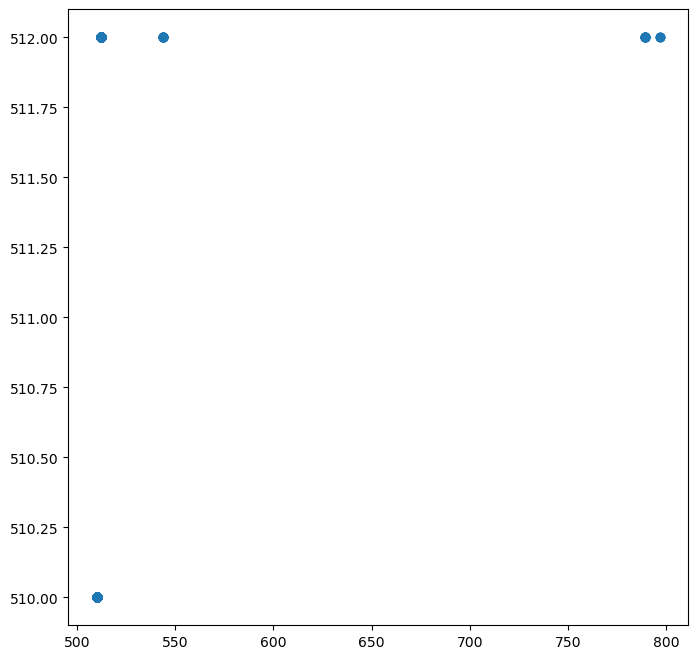

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(train_df['width'], train_df['height'])

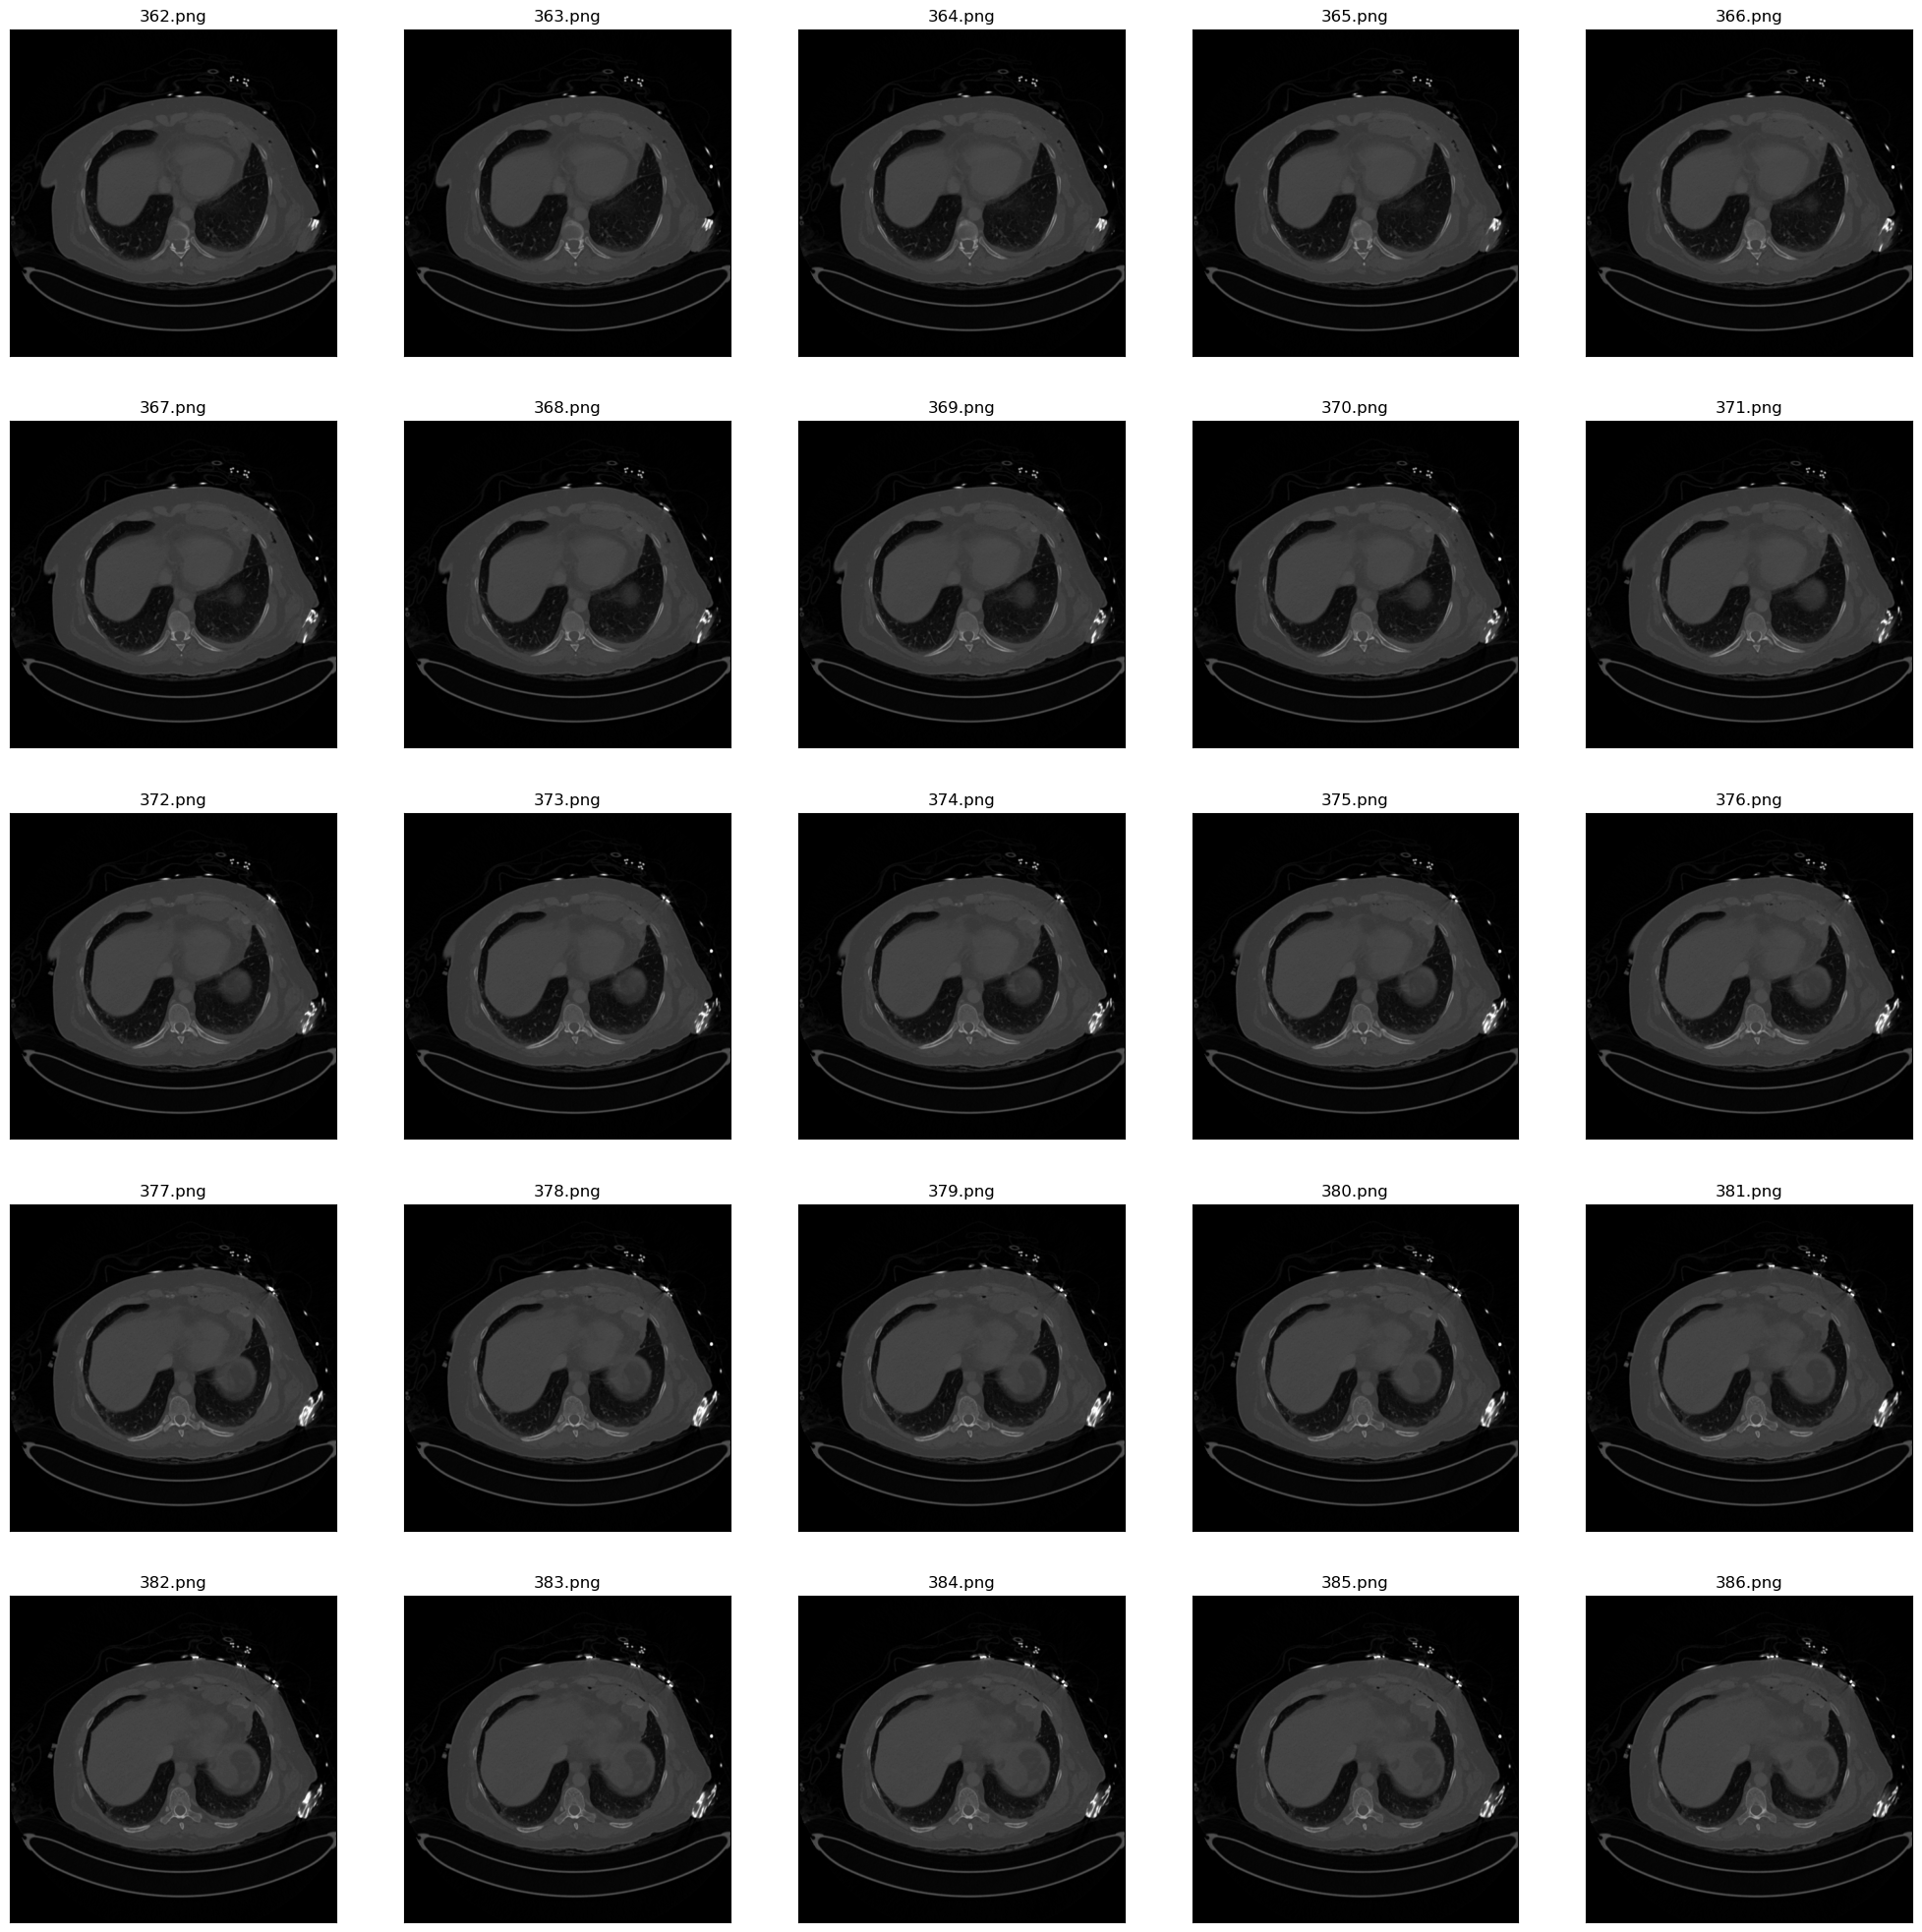

In [131]:
paths = train_df[train_df.width<700].image_path.iloc[0:25]

plt.figure(figsize=(25,25))
for i, path in enumerate(paths):
    plt.subplot(5, 5, i+1)
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    plt.title(path.split('/')[-1])
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [132]:
train_df.to_csv(f'{IMG_DIR}/train.csv',index = False)
test_df.to_csv(f'{IMG_DIR}/test.csv',index = False)